# Topological analysis of hippocampal CA1 neural cofiring networks
## Gava et al, 2021 -- [link](https://www.mrcbndu.ox.ac.uk/sites/default/files/Gava%20et%20al%202021%20Nat%20Neurosci_In%20press.pdf)

### Import libraries

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import pickle as pickle
import networkx as nx
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# Custom libraries
import util_func as uf
import difference_estimation_plot as dpl

rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
%matplotlib inline
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
# no warning display
warnings.filterwarnings('ignore')

### Set parameters

In [2]:
# directory
homeDir = os.getcwd() # make sure it's the folder level where the script resides
recday = 'mhb10-161111'
# global parameters
sampT = 50*10e-6 # spike sampling period 50us / 20kHz
trackSamp = 32/1250 # tracking sampling period
track2cm = 150/37 # from pixels to cm
# plotting parameters
RED = sns.hls_palette(20,l=.5,s=1)[0]
PURPLE = sns.hls_palette(10,l=.45,s=1)[8]
BLUE = sns.hls_palette(15,l=.6,s=1)[9]#sns.xkcd_palette(['windows blue'])[0]
GREEN = sns.hls_palette(8,l=.4,s=.8)[3]
ORNG = sns.hls_palette(20,l=.5,s=1)[2] #sns.color_palette('husl',8)[1]
GRAY = [0.6,0.6,0.6]
colorsG = [GRAY,RED,ORNG,BLUE,PURPLE,GREEN]
RED_G = sns.color_palette('husl')[0] # used for graph visualisation
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
# sessions labels
sess_label = {'cpp':['Exposure','Pre-test','+Suc.','+Wat.','CPP test','Re-exposure'],
              'spp':['Exposure','Pre-test','Nov 1','Nov 2','CPP test','Re-exposure'],
              'novel-only':['Exposure','Nov 1a','Nov 1b','Nov 1c','Nov 1d','Re-exposure'],
              'familiar-reward':['Exposure','Fam 2a','Nov 1','Nov 2','Fam 2d','Re-exposure']}

### Load example recording

In [3]:
# Load data from example recording session Exposure -- i.e. exploration of a familiar environment
ses_id = 1 # the Exposure session is the first of the recording day
recDir = homeDir+'/data/recday/'
bsnm = recDir + recday # name of the whole recording day
sesfile = bsnm + '_' + str(ses_id) # session name
# Load session times @ spikes sampling rate (20kHz)
stages = uf.loadStages(bsnm)
sessMaxTimes = np.array(stages['end_t'] - stages['start_t'])
maxT = sessMaxTimes[ses_id-1]
# Load units putative identity
des = uf.loadUnits(sesfile)['des'] # load units putative identity
indP = des=='p1' # principal cells
indI = (des=='b1')|(des=='i1') # interneurons
print(f'We have {np.sum(indP)} putative principal cells and {np.sum(indI)} putative interneurons!')

We have 74 putative principal cells and 6 putative interneurons!


In [4]:
import importlib
importlib.reload(uf)

<module 'util_func' from '/Users/GiuseppePietro/Papers/Gava et al_2021/network_cofiring/util_func.py'>

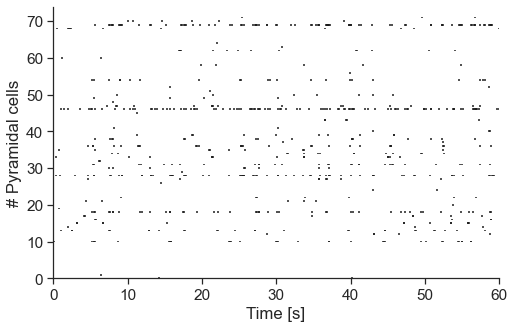

In [12]:
# Load the spiketrains of all the units
res,clu = uf.loadSpikeTimes(sesfile, res2eeg=1)
spiketrains = [res[clu==i] for i in np.unique(clu)] # all neurons
spiketrains_p1 = [res[clu==i] for i in np.unique(clu) if indP[i]] # select only p1 cells
# raster plot
sns.set(style='ticks',font_scale=1.4)
fig = plt.figure(figsize=(8,5))
fig.patch.set_facecolor('white')
ist = 500; ifin = 560 # start/end times in sec
start = ist/sampT; fin = ifin/sampT # start/end times in samples
spk2d = [spkTemp[(spkTemp>start) &\
                 (spkTemp<fin)] for spkTemp in spiketrains] # spikestamps to visuualise
# np.random.shuffle(spk2d) # shuffle neurons ID (NOT spike timing)
plt.eventplot(spk2d,color='k',linelengths=0.5)
plt.ylim(0,len(spiketrains_p1))
# plt.yticks([-1,10,20,30,40,50,60,len(spikes)+1], [1,'','','','','','',len(spikes)])
plt.ylabel('# Pyramidal cells')
plt.xlim(start-100,fin)
plt.xticks(np.linspace(start,fin,7),np.arange(0,ifin-ist+1,10))
plt.xlabel('Time [s]')
sns.despine()

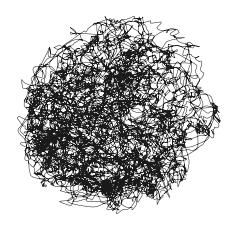

In [11]:
# bin the spiketrains to obtain an activity matrix sampled @1250Hz -- LFP sampling rate
dt = .8 # sampling bin size in ms
dT = (dt*10e-3)/sampT # bin size from ms to samples
std = 50 # gaussian std in samples - 40ms
bins = np.arange(0,maxT,dT)
actmat = uf.bin_spikes(np.asarray(spiketrains_p1).T,bins)
# smooth activity matrix with Gaussian kernel
actmat_s = uf.matGaussianSmooth(actmat.T,std,4*std)[0].T

# load mouse tracking data
track = uf.loadTracking(sesfile)
thrV = 2 * trackSamp * track2cm # speed thr -- 2 cm/s
active = uf.getActiveTrack(track, thrV)
# plot tracking when the animal is active
plt.figure(figsize=(4,4))
plt.plot(track['x'][active], track['y'][active], color='k', alpha=1, linewidth=0.5)
plt.axis('off');

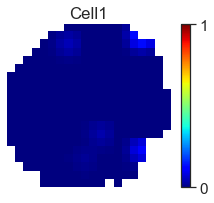

In [32]:
# show example place cell?
cid = 1
occmap, placemap, placemapS, spatialInfo, spatialCoh = uf.getPlaceMap(track, spiketrains[cid], active)
placemapS[occmap==0] = np.nan
# plot
plt.figure(figsize=(4,3))
plt.imshow(placemapS.T,cmap='jet',vmin=-0.001,origin='lower')
plt.axis('off')
plt.title(f'Cell{cid}')
# draw the colorbar
cbar = plt.colorbar()
_,vMax = plt.gci().get_clim()
if vMax<1: vMax = 1
plt.clim(vmin=-0.001,vmax=vMax)
cbar.set_ticks([0,vMax])

In [7]:
# extraction of theta cycles timestamps
thetafile = sesfile + '.theta.cycles'
thetacycles = np.load(thetafile) # format: (theta cycle id, cycle point references)
theta = np.zeros(actmat.shape[0], dtype=bool) # boolean vector to index theta samples
for t in thetacycles: theta[t[0]:t[-1]] = True
# upsample (linearly) active tracking indexes to match theta sampling rate
downx = np.linspace(0,maxT,len(active))
upx = np.linspace(0,maxT,actmat.shape[0])
f = interp1d(downx,active)
active_up = f(upx) # upsampled
theta_active = np.logical_and(theta, active_up) # bool indexes for theta and active movement
# actmat filtered by active samples, sampled @1250Hz (LFP rate)
actmat_a = actmat_s[theta_active]
# theta-binned actmat
actmat_the = uf.get_actmat_the(actmat, thetacycles)

In [8]:
# binless smoothed correlation graph @1250Hz
Gcorr = uf.corrGraph(actmat_a) # active
print('Obtained correlation graph...')
# theta-binned correlation graph
Gtheta = uf.corrGraph(actmat_the) # theta binned actmat
print('Obtained theta-binned correlation graph...')
# GLM graph -- allows us to separate the effect of individual cells from the population drive
Gglm,Gpop = uf.GLMgraph_lin(actmat_the, symm=0) # Gglm=individual cell coupling -- Gpop=population drive effects
print('Obtained theta-binned GLM graph...')

Obtained correlation graph...
Obtained theta-binned correlation graph...
Obtained theta-binned GLM graph...


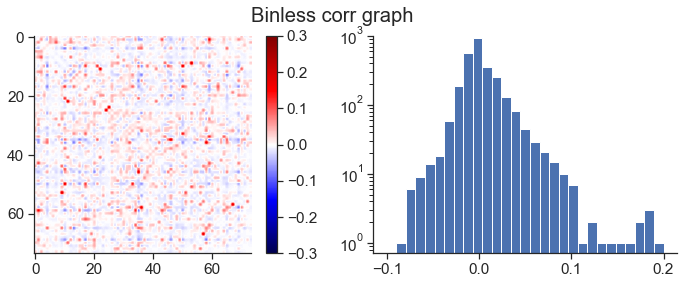

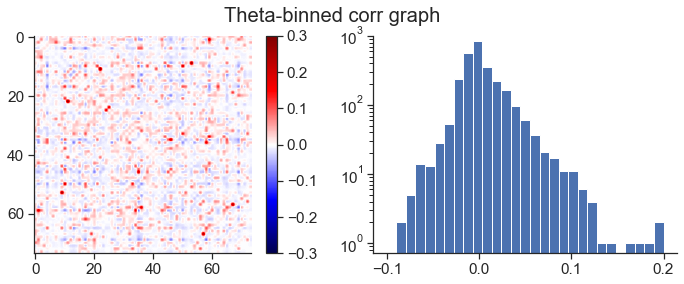

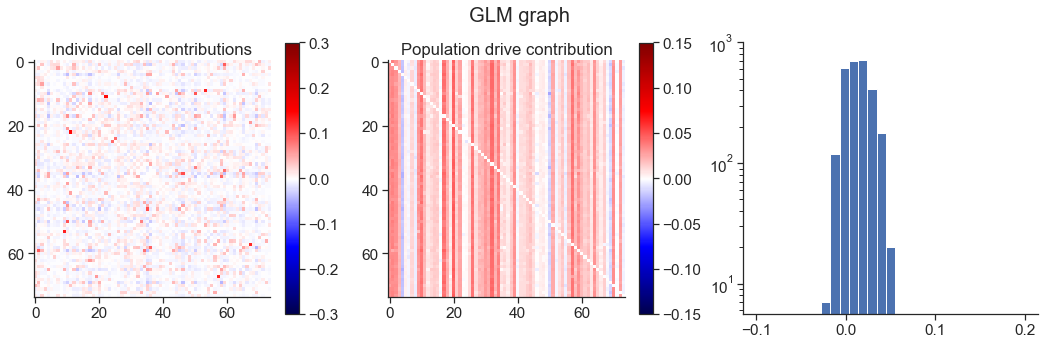

In [25]:
# Plot co-firing graphs
bins = np.linspace(-.1,.2,30)
# binless correlation graph @1250Hz
plt.figure(figsize=(12,4))
plt.suptitle('Binless corr graph')
plt.subplot(121)
g = Gcorr
plt.imshow(g, cmap='seismic', vmin=-.3, vmax=.3); plt.colorbar()
plt.subplot(122)
plt.hist(g[np.triu_indices_from(g)], bins=bins);
plt.yscale('log')
plt.ylim(0,1e3)
sns.despine()
# theta binned graph
plt.figure(figsize=(12,4))
plt.suptitle('Theta-binned corr graph')
plt.subplot(121)
g = Gtheta
plt.imshow(g, cmap='seismic', vmin=-.3, vmax=.3); plt.colorbar()
plt.subplot(122)
plt.hist(g[np.triu_indices_from(g)], bins=bins);
plt.yscale('log')
plt.ylim(0,1e3)
sns.despine()
# GLM individual contribution graph
plt.figure(figsize=(18,5))
plt.suptitle('GLM graph')
plt.subplot(131)
g = Gglm
plt.imshow(g, cmap='seismic', vmin=-.3, vmax=.3); plt.colorbar()
plt.title('Individual cell contributions')
plt.subplot(132)
g = Gpop
plt.imshow(g, cmap='seismic', vmin=-.15, vmax=.15); plt.colorbar()
plt.title('Population drive contribution')
plt.subplot(133)
plt.hist(g[np.triu_indices_from(g)], bins=bins);
plt.yscale('log')
plt.ylim(0,1e3)
sns.despine()

### Load example binless co-firing graphs used in the paper/study and compute their topological measures

One co-firing graph was obtained per session (e.g. enclosure, pre-test, re-exposure, ...), each of them is represented by its $NxN$ adjacency matrix (N is the number of principal cells recorded on the day).

Each of the matrix elements $(i,j)$ was obtained as the Pearson correlation coefficient between the spiketrains of the neuron $i$ and $j$, each smoothed through convolution with a $40ms$ Gaussian.

In [14]:
### Load names of precomputed principal cells co-firing graphs (i.e. co-firing matrices)
# obtain list of recording days
for _,folders,file in os.walk(homeDir+'/data/networks'):
    dataList = file
# initialise batch variables
exp_names = []
w = {}; clu = {}; plw = {}; netD = {}

# BATCH WORK
for dd,dataname in enumerate(dataList): # loop over recording days / experiments
    # load data for single exp
    exp_name = dataname.split('.')[0].split('_')[-1] # obtain the experiment label
    exp_names.append(exp_name)
    bsnm = dataname.split('_')[0]
    print(f'\n- processing {exp_name} example...')
    # load data
    with open(homeDir+'/data/networks/'+dataname,'rb') as f:
        data = pickle.load(f)
    allKEYS = list(data.keys())
    allKEYS_ = allKEYS.copy() # make a deep copy for extra looping within the loop
    print(f'# p1 neurons: {data[allKEYS[0]].shape[0]}\nSessions to analyse: {allKEYS}')
    w[exp_name] = {}; clu[exp_name] = {}; plw[exp_name] = {}; netD[exp_name] = {}
    # loop over sessions
    for k,k2 in zip(sess_label[exp_name],allKEYS): # loop over sessions
        g = data[k2]
        w[exp_name][k] = g
        # networkx measures
        graph = nx.Graph(g)
        clu[exp_name][k] = list(uf.clustering(graph,weight='weight').values())
        plw[exp_name][k] = uf.wNetGeoPathLength(g.copy())
        # matrix topological distance analysis
        netRef = g + np.identity(g.shape[0]) # fill diaginal to ensure matrix positivness
        keys2 = zip(sess_label[exp_name],allKEYS_) # indeces to loop over sessions again
        for kk,kk2 in keys2: # loop again over sessions to obtain topological distances
            if kk==sess_label[exp_name][0]: # initialise dict if first iter
                netD[exp_name][k] = {} 
            g = data[kk2] # other network from which to measure the distance
            if kk==k: # self distance case (add noise to avoid distance of 0)
                perturb = uf.symmMatPerturb(g,scale=1); np.fill_diagonal(perturb,0)
                gPosDef = g + np.identity(g.shape[0])
                comp = gPosDef + perturb
                netD[exp_name][k][kk] = uf.distRiemLE(netRef,comp)
            else: # different session from the reference one
                gPosDef = g + np.identity(g.shape[0])
                netD[exp_name][k][kk] = uf.distRiemLE(netRef,gPosDef)
print(f'\nThe available experiments are {exp_names}')


- processing spp example...
# p1 neurons: 70
Sessions to analyse: ['f 1_1', 'n1n2 pretest_2', 'n 1_3', 'n 2_4', 'n1n2 test_5', 'f 1_6']

- processing novel-only example...
# p1 neurons: 47
Sessions to analyse: ['f 1_1', 'n 1a_2', 'n 1b_3', 'n 1c_4', 'n 1d_5', 'f 1_6']

- processing cpp example...
# p1 neurons: 80
Sessions to analyse: ['f 1_1', 'n1n2 pretest_2', 'n2 suc_3', 'n1 wat_4', 'n1n2 test_5', 'f 1_6']

- processing familiar-reward example...
# p1 neurons: 74
Sessions to analyse: ['f 1_1', 'f 2a_2', 'f 2suc_3', 'f 2wat_4', 'f 2d_5', 'f 1_6']

The available experiments are ['spp', 'novel-only', 'cpp', 'familiar-reward']


### Visualise one example co-firing graph and its adjacency matrix

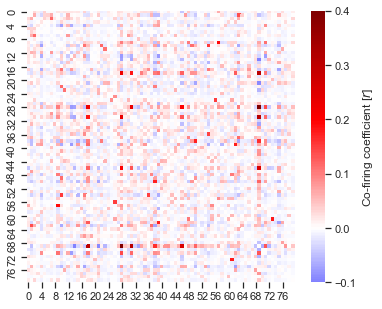

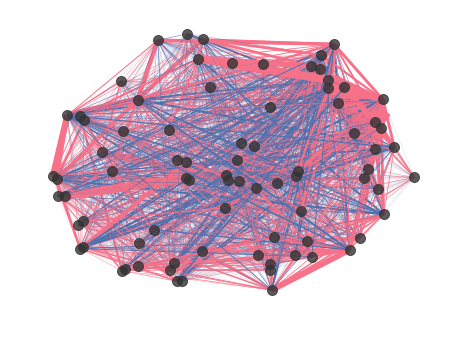

In [31]:
# select co-firing graph to visualise
EXP = 'cpp' # recording day index -- CPP
SID = 0 # exposure session
K = sess_label[EXP][SID] # session index -- exposure
# obtain the graph
adjmat = w[EXP][K]
graph = nx.Graph(adjmat)
# plot adj matrix
sns.set(style='ticks', font_scale=1)
plt.figure(figsize=(6,5))
sns.heatmap(adjmat, cbar=True, vmax=.4, vmin=-.1, center=0,
            cmap='seismic', cbar_kws={'label':'Co-firing coefficient [$r$]'})
# visualise graph with networkX
plt.figure(figsize=(8,6))
uf.plotWeightedGraph(adjmat, graphType='spring', scale=0.4, Labels=0,
                     nodeC=[.2,.2,.2], nodeSize=100, posC=RED_G)

Session Exposure: co-firing S 0.07 | geo path length 84.2 | clust coeff -0.001
Session Pre-test: co-firing S 0.06 | geo path length 73.2 | clust coeff 0.006
Session +Suc.: co-firing S 0.09 | geo path length 59.4 | clust coeff 0.006
Session +Wat.: co-firing S 0.10 | geo path length 79.2 | clust coeff 0.030
Session CPP test: co-firing S 0.13 | geo path length 52.5 | clust coeff 0.121
Session Re-exposure: co-firing S 0.10 | geo path length 67.6 | clust coeff 0.056


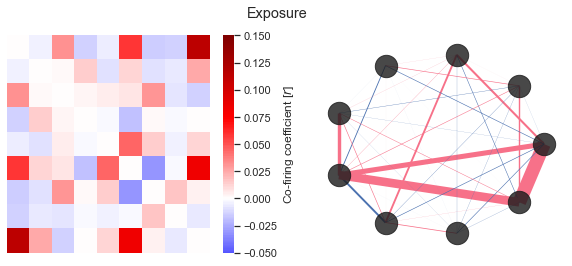

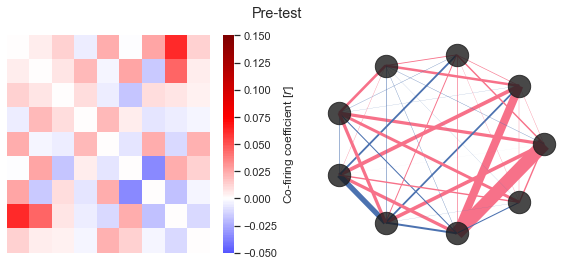

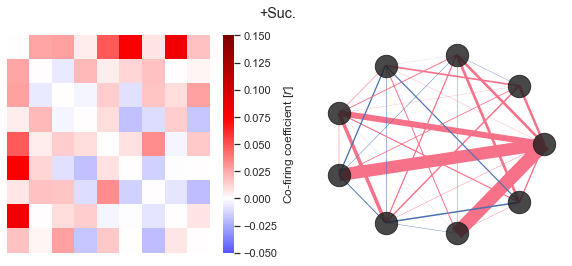

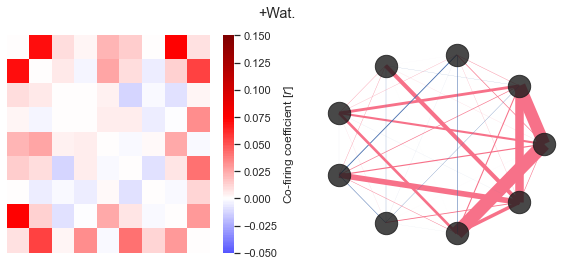

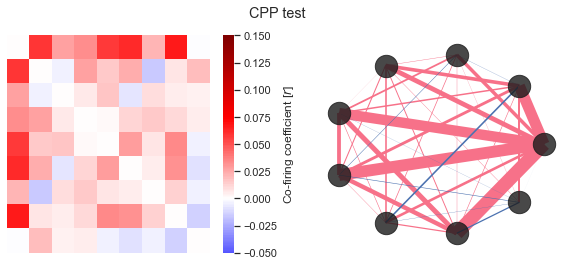

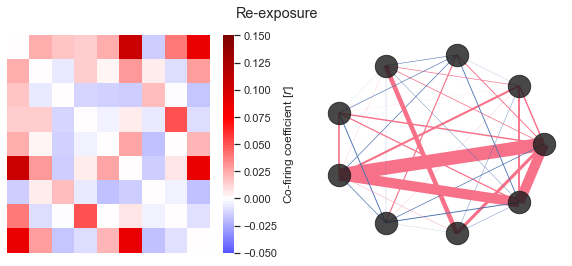

In [32]:
### Plot subgraphs across sessions
sns.set(style='ticks',font_scale=1)
nc = 7 # number of cells to display
for k in sess_label[EXP]:
    adjmat = w[EXP][k] #  graph copy to obtain indiv units to visualise
    if K==sess_label[EXP][0]: # obtain indice of most correlated units to form subgraph to display
        indd = np.argsort(np.std(np.abs(adjmat),0))[::-1] # select the nodes with the largest std
        IND = [10,52,14,65,59,50,23,25,49] # picked from visual inspection
        IX = np.ix_(IND,IND) # matrix indeces
    # obtain subgraph measures
    GGG = adjmat[IX] # extract  subgraph
    G = nx.Graph(GGG)
    avgS = np.mean(GGG.sum(0)) # average neurons co-firing strength
    avgClu = np.mean(list(uf.clustering(G,weight='weight').values())) # average clustering
    avgPL = np.nanmean(uf.wNetGeoPathLength(GGG.copy())) # average PL
    # PLOTTING
    plt.figure(figsize=(10,4))
    plt.suptitle(k)
    plt.subplot(121)
    sns.heatmap(GGG, cmap='seismic', center=0, vmin=-.05 ,vmax=.15,
                cbar_kws={'label':'Co-firing coefficient [$r$]'})
    plt.axis('off');
    plt.subplot(122)
    uf.plotWeightedGraph(GGG, graphType='circ', scale=1.5, nodeC='k', posC=RED_G)
    print('Session %s: co-firing S %.2f | geo path length %.1f | clust coeff %.3f'\
          %(k,avgS,avgPL,avgClu))

## Visualise the examples co-firing topology dynamics over sessions

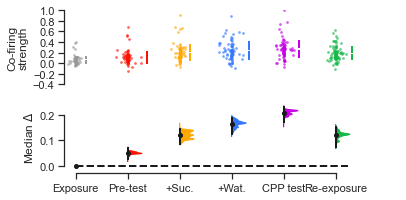

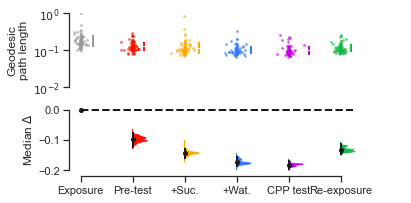

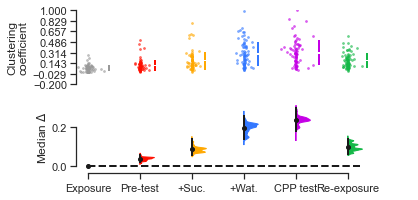

In [42]:
### Visualise the cofiring topological measures across sessions

# functions to index topological measures
OUT = lambda f,k: f[k][n][:,:]
IO = lambda f,k: np.asarray(f[n])[:]

# set plotting parameters
sns.set(style='ticks', font_scale=1.2)

# choose which dataset to visualise
EXP = 'cpp'
KEYS = sess_label[EXP]

# NETWORK STRENGTH
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = np.nansum(w[EXP][k],1)
# normalise it
norm = np.max([np.max(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = m_out[k]
ax, m, p = dpl.estimation_plot(df, ci=.99, nsh=1000, operation=np.median,
                           swarmPlot_kw={'label':'Co-firing\nstrength'},
                           figsize=(6,3), color_palette=colorsG, paired=1, trend=0)
ymin = -0.4; ymax = 1
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,8))
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

# GEO PATH LENGTH
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = np.nanmean(plw[EXP][k],1)
# normalise it
norm = np.max([np.nanmax(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
x = [m_out[k] for k in KEYS]
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = x[nk]
ax, m, p = dpl.estimation_plot(df, ci=.99, nsh=1000, operation=np.median,
                           swarmPlot_kw={'label':'Geodesic\npath length'},
                           figsize=(6,3), color_palette=colorsG, paired=1, trend=0)
# ymin = -2; ymax = 0
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,3))
ax[0].set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^0$'])
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

# CLUSTERING
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = clu[EXP][k]
# normalise it
norm = np.max([np.nanmax(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = m_out[k]
# plotting
ax, m, p = dpl.estimation_plot(df, ci=.99, nsh=1000, operation=np.median,
                           swarmPlot_kw={'label':'Clustering\ncoefficient'},
                           figsize=(6,3), color_palette=colorsG, paired=1, trend=0)
ymin = -0.2; ymax = 1
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,8))
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$');

### Topological distance analysis

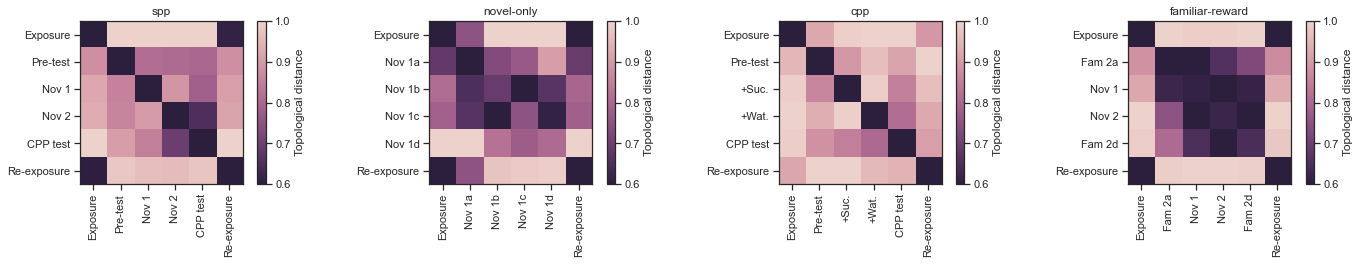

In [98]:
plt.figure(figsize=(24,3))
for ne,EXP in enumerate(exp_names): # loop over datasets
    KEYS = sess_label[EXP]
    topoDmat = np.zeros((len(KEYS),len(KEYS)))
    for nk,k in enumerate(KEYS):
        temp = np.asarray([np.absolute(netD[EXP][k][kk]) for kk in KEYS]) # obtain row of the matrix
        topoDmat[:,nk] = temp/np.max(temp) # normalise
    plt.subplot(1,4,ne+1)
    plt.title(EXP)
    plt.imshow(topoDmat,cmap=sns.cubehelix_palette(20,reverse=True,as_cmap=True))
    cbar = plt.colorbar(); plt.clim(0.6,1); cbar.set_label('Topological distance')
    plt.xticks(range(6),sess_label[EXP],rotation=90); plt.yticks(range(6),sess_label[EXP])

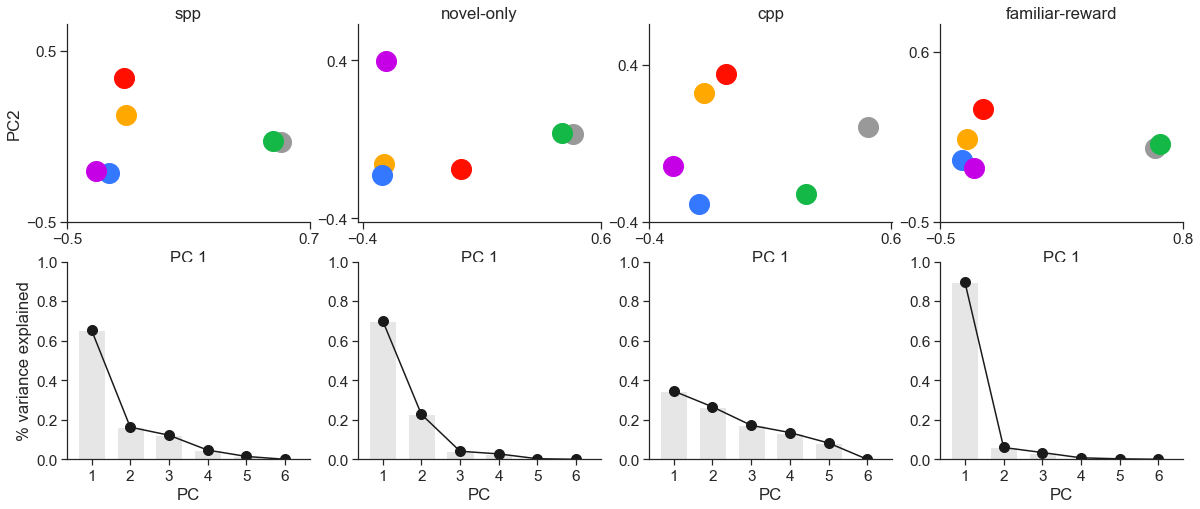

In [23]:
# pca projection of topological distance matrices
sns.set(style='ticks',font_scale=1.4)
plt.figure(figsize=(20,8))
for ne,EXP in enumerate(exp_names): # loop over datasets
    KEYS = sess_label[EXP]
    topoDmat = np.zeros((len(KEYS),len(KEYS)))
    for nk,k in enumerate(KEYS):
        temp = np.asarray([netD[EXP][k][kk] for kk in KEYS]) # obtain row of the matrix
        topoDmat[:,nk] = temp/np.max(temp) # normalise
    # Apply PCA to the topological distance matrices to visualise the sessions in a low-dim space
    pcaAll = PCA(n_components=len(KEYS))
    xtr = pcaAll.fit_transform(topoDmat)
    # plot projections
    plt.subplot(2,4,ne+1)
    for i in range(len(xtr)):
        plt.plot(xtr[i,0],xtr[i,1], 'o',color=colorsG[i],markersize=20,alpha=1)
    plt.title(EXP)
    MIN = np.min(xtr[:,0])-0.1; MAX = np.max(xtr[:,0])+0.1
    plt.xlim(MIN,MAX); plt.ylim(MIN,MAX)
    plt.xlabel('PC 1')
    if not ne: plt.ylabel('PC2')
    plt.xticks([np.round((MIN)*10)/10,np.round(MAX*10)/10])
    plt.yticks([np.round(MIN*10)/10,np.round((MAX-0.2)*10)/10])
    plt.tick_params(length=7)
    sns.despine()
    # plot PCs variance explained
    plt.subplot(2,4,ne+5)
    toP = pcaAll.explained_variance_ratio_
    plt.plot(toP,'ko',markersize=10)
    plt.plot(toP,'k')
    plt.bar(range(len(toP)),toP,width=0.7,color=[0.9,0.9,0.9])
    sns.despine()
    plt.xlabel('PC')
    if not ne: plt.ylabel('% variance explained')
    plt.xticks(range(6), range(1,7))
    plt.ylim(0,1)
    sns.despine()